In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve

import IPython
import pyroomacoustics as pra

(2, 4)
[[0.  0.  2.2 2.2]
 [0.  1.1 1.1 0. ]]


(-0.1, 1.2)

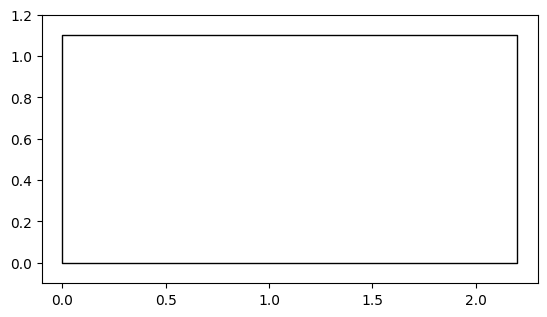

In [2]:
# 创建 2D 房间节点（顺时针旋转）
corners = np.array([[0, 0], [0, 1.1], [2.2, 1.1], [2.2, 0]]).T
print(corners.shape)
print(corners)

# 由 2D 空间节点构建 2D 房间
room = pra.Room.from_corners(corners)

# 绘制 2D 房间
fig, ax = room.plot()
ax.set_xlim([-0.1, 2.3])
ax.set_ylim([-0.1, 1.2])

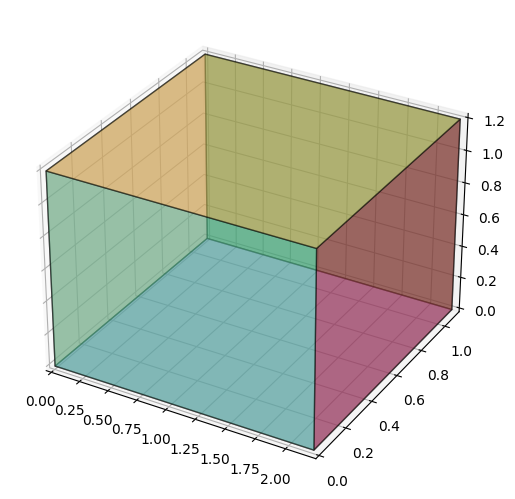

In [3]:
room.extrude(1.2)

fig, ax = room.plot()

为了仿真声音在房间的传播需要进行以下几个步骤的设置：

- (1) 创建房间模型
- (2) 添加声源和麦克风
- (3) 房间脉冲响应（RIR）生成器与传播仿真

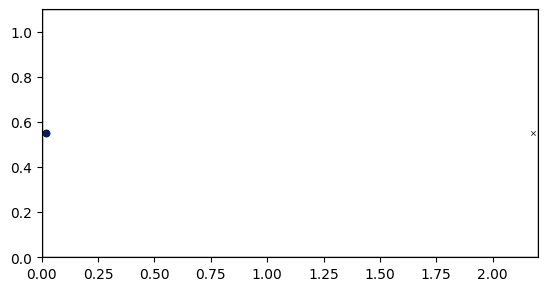

In [14]:
# 原始噪声信号
fs, signal_firt_channel = wavfile.read("google_speech_commands/_background_noise_/pink_noise.wav")

# 向房间中添加信号源，首先构造一个 2D 房间，并设置房间的频率属性、ray_tracing、空气吸收率（air_absorption），最大阶数（max_order）、材料（materials）参数进行设置，并生成新的 2D 房间 room 对象
room = pra.Room.from_corners(corners, fs=fs, ray_tracing=True, max_order=3, materials=pra.Material(0.2, 0.15), air_absorption=True)

# 设置

# 使用 add_source() 方法在 [0.02, 0.55] 处添加信号源 signal
room.add_source([0.02, 0.55], signal=signal_firt_channel)

# 同样下面添加麦克风
room.add_microphone([2.18, 0.55], fs)

# 绘制房间和信号源
fig, ax = room.plot()



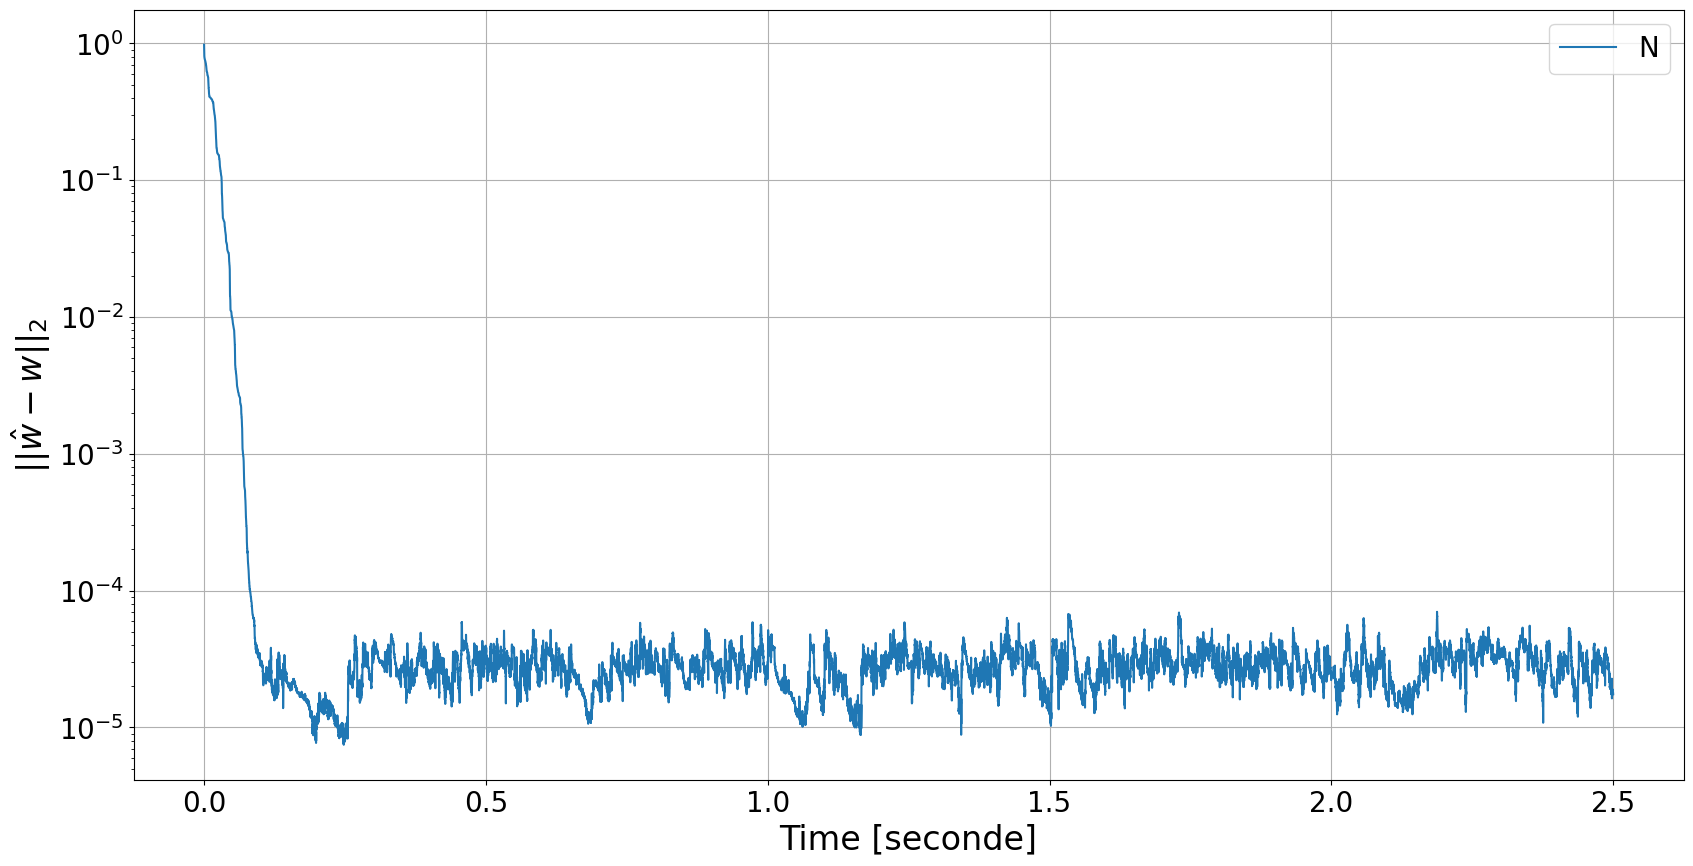

In [9]:
# 使用 wavfile.read方法读取 arctic_10001.wav 音频数据，并返回频率 fs 和信号 signal 数据

# 原始噪声信号
fs, signal_firt_channel = wavfile.read("google_speech_commands/_background_noise_/pink_noise.wav")


# 下面设置自适应滤波器
# 滤波器参数
length = 15
n_samples = 40000
# fs 这里不用设置，因为读取信号的时候已经确定
SNR = 10

# 设置随机滤波器参数
w = np.random.randn(length) # 滤波器权重参数
w /= np.linalg.norm(w)      # 对滤波器参数进行范数正则化处理

# 第二个通道信号（用于抵消原始噪声）
signal_second_channel = fftconvolve(signal_firt_channel, w)[:n_samples]

signal_second_channel = signal_second_channel + np.random.randn(n_samples) * 10 ** (-SNR / 20.)

# NLMS 滤波器
filter = dict(
    filter = pra.adaptive.NLMS(length, mu=0.5),
    error  = np.zeros(n_samples),
)

# 滤波器参数迭代更新
for i in range(n_samples):
    filter["filter"].update(signal_firt_channel[i], signal_second_channel[i])
    filter["error"][i] = np.linalg.norm(filter["filter"].w - w)

# 绘图
plt.figure()
plt.semilogy(np.arange(n_samples) / fs, filter["error"])

plt.legend('NLMS', fontsize=20)
plt.ylabel("$\||\hat{w}-w\||_2$", fontsize=24)
plt.xlabel("Time [seconde]", fontsize=24)

# 设置坐标轴刻度的字体大小
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

plt.grid()
fig = plt.gcf()
fig.set_size_inches(20, 10)

